In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import MDAnalysis.lib.distances
import nglview as nv

import numba
from numba import jit

_ColormakerRegistry()

In [2]:
#Path to structure and trajectory files
structf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd.gro"
trajf = "/Volumes/Akash_SSD/starter_project/ubiquitin/chestnut/unfold_fold/i-3.5/1/indus_fwd_mol.xtc"

#Create universe
u = mda.Universe(structf,trajf)
protein = u.select_atoms("protein")

In [3]:
#Visualize using nglview
from nglview.contrib.movie import MovieMaker
view = nv.show_mdanalysis(protein)
movie = MovieMaker(view, output='my.gif', in_memory=True)
movie.make()

You have to install moviepy, imageio and ffmeg
pip install moviepy==0.2.2.11
pip install imageio==1.6


IntProgress(value=0, description='Rendering ...', max=200)

# Ubiquitin - atom selections

GROMACS groups: http://manual.gromacs.org/documentation/2019-rc1/reference-manual/analysis/using-groups.html

MDAnalysis selections: Look up documentation.

Looking through the topology file:
- 1st residue - NMET: MET with charged N-terminus (NH3+). N-terminal atom is N. Terminal amide H's are H1, H2, H3 
- Last residue - CGLY: GLY with charged C-terminus (COO-). C-terminal atom is C. Terminal carboxylic O's are OC1, OC2
- Amide nitrogen is N
- Amide hydrogen is H
- Alpha carbons on backbone are CA.
- Alpha hydrogen is HA (for GLY, HA1 and HA2)
- Acid carbons on backbone are C.
- Acid oxygens on backbone are O.

In [4]:
#   H HA O
#   | |  "
#-(-N-CA-C-)-
#     |
#     R

In [5]:
print(len(protein))
#GROMACS make_ndx: 1231

1231


In [6]:
protein_heavy = u.select_atoms("protein and not type H")
print(len(protein_heavy))
#GROMACS make_ndx Protein-H: 602 

602


In [7]:
C_alpha = u.select_atoms ("protein and name CA")
print(len(C_alpha))
#GROMACS make_ndx C-alpha: 76

76


In [8]:
# In MDAnalysis N, CA, C, O are backbone
mda_backbone = u.select_atoms("backbone")
alt_mda_backbone = u.select_atoms("name CA or name C or name N or name O")
print(len(mda_backbone))
print(len(alt_mda_backbone)) #same

# In GROMACS, N, CA and C are backbone
backbone = u.select_atoms("name CA or name C or name N")
print(len(backbone))

#GROMACS make_ndx: 228

303
303
228


In [9]:
# In GROMACS, all atoms except N, CA, C, O, backbone amide hydrogens, 
# oxygens in C-terminus and hydrogens on the N-terminus are side chain atoms
side_chain = u.select_atoms("""protein and not (name N or name CA or name C or name O or name H
                            or name H1 or name H2 or name H3 or name OC1 or name OC2)""")
print(len(side_chain))

#GROMACS make_ndx SideChain: 851

851


In [10]:
# In GROMACS, protein side chain excluding all H is side_chain_heavy
side_chain_heavy = u.select_atoms("""protein and not(name N or name CA or name C or name O 
                                     or name OC1 or name OC2 or type H)""")
print(len(side_chain_heavy))

#GROMACS make_ndx SideChain-H = 297

297


In [11]:
# O's and terminal O's excluded from GROMACS backbone
backbone_oxygens = u.select_atoms("name O or name OC1 or name OC2")
print(len(backbone_oxygens))

77


In [12]:
assert(len(backbone) + len(backbone_oxygens) + len(side_chain_heavy) == len(protein_heavy))
#228 + 77 + 297 = 602

# Native Contacts in reference structure (unbiased production run)

Determine number of contacts between side-chain heavy atoms belonging to residues $i$ and $j$ such that $|i - j| > 3$ and the distance between the atoms is < $d \mathring{\textrm{A}}$ 

In [13]:
refstructf = "/Volumes/Akash_SSD/starter_project/ubiquitin/local/equil/prod.gro"
reftrajf = "/Volumes/Akash_SSD/starter_project/ubiquitin/local/equil/prod.xtc"

refu = mda.Universe(refstructf, reftrajf)
refprotein = refu.select_atoms("protein")

In [14]:
side_heavy_sel = "protein and not(name N or name CA or name C or name O or name OC1 or name OC2 or type H)"

In [33]:
### TEST - MATRIX RESHAPING
mat = [[11,12,13,14],
       [21,22,23,24],
       [31,32,33,34],
       [41,42,43,44],
       [51,52,53,54]]
iidx = [1, 2, 3, 4, 5]
jidx = [1, 2, 3, 4]
print(np.array([(i,j) for i in iidx for j in jidx]))

mat = np.array(mat)
print(np.reshape(mat, (mat.shape[0]*mat.shape[1],)))

[[1 1]
 [1 2]
 [1 3]
 [1 4]
 [2 1]
 [2 2]
 [2 3]
 [2 4]
 [3 1]
 [3 2]
 [3 3]
 [3 4]
 [4 1]
 [4 2]
 [4 3]
 [4 4]
 [5 1]
 [5 2]
 [5 3]
 [5 4]]
[11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 44 51 52 53 54]


In [58]:
skip = 1
nres = len(refprotein.residues)

step = 0
contacts = []
l = len(refprotein.residues.atoms)
contactmatrix = np.zeros((l,l))

####CUTOFF####
cutoff = 6

for ts in refu.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0
    atomiccontacts = np.zeros((nres, nres))

    for i in range(nres):
        heavy_side_i = refprotein.residues[i].atoms.select_atoms(side_heavy_sel)
        heavy_side_j = refprotein.residues[i+4:].atoms.select_atoms(side_heavy_sel)
        dmatrix = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
        ijc = np.count_nonzero(dmatrix < cutoff)
        ncontacts += ijc
        iidx = heavy_side_i.indices
        jidx = heavy_side_j.indices
        
        for i in range(dmatrix.shape[0]):
            for j in range(dmatrix.shape[1]):
                contactmatrix[iidx[i], jidx[j]] += dmatrix[i,j]
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

refcontacts = np.array(contacts)
for i in range(contactmatrix.shape[0]):
    for j in range(contactmatrix.shape[1]):
        contactmatrix[i,j] = max(contactmatrix[i,j], contactmatrix[j,i])

Step = 1, time = 0.0 ps, contacts = 1107
Step = 2, time = 10.0 ps, contacts = 1074
Step = 3, time = 20.0 ps, contacts = 1099
Step = 4, time = 30.0 ps, contacts = 1049
Step = 5, time = 40.0 ps, contacts = 1016
Step = 6, time = 50.0 ps, contacts = 1013
Step = 7, time = 60.0 ps, contacts = 1073
Step = 8, time = 70.0 ps, contacts = 1066
Step = 9, time = 80.0 ps, contacts = 1072
Step = 10, time = 90.0 ps, contacts = 1034
Step = 11, time = 100.0 ps, contacts = 1016
Step = 12, time = 110.0 ps, contacts = 1028
Step = 13, time = 120.0 ps, contacts = 1083
Step = 14, time = 130.0 ps, contacts = 1069
Step = 15, time = 140.0 ps, contacts = 1035
Step = 16, time = 150.0 ps, contacts = 1060
Step = 17, time = 160.0 ps, contacts = 1061
Step = 18, time = 170.0 ps, contacts = 1037
Step = 19, time = 180.0 ps, contacts = 1057
Step = 20, time = 190.0 ps, contacts = 1036
Step = 21, time = 200.0 ps, contacts = 1071
Step = 22, time = 210.0 ps, contacts = 1085
Step = 23, time = 220.0 ps, contacts = 1063
Step = 2

In [1]:
plt.hist(refcontacts[:,1], bins=50)

NameError: name 'plt' is not defined

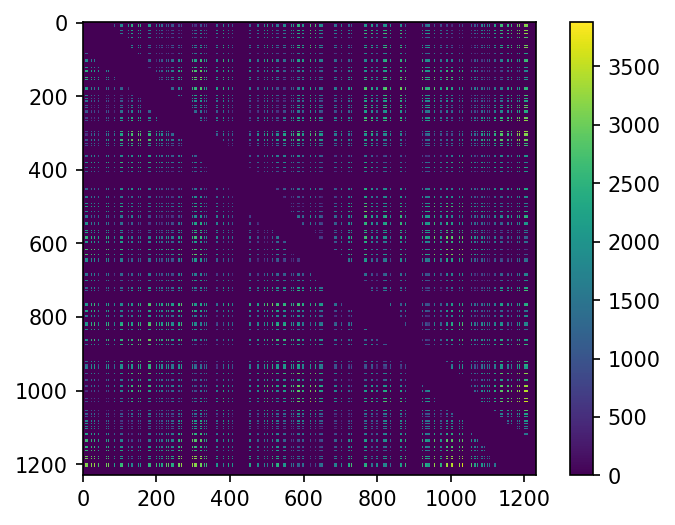

In [60]:
plt.figure(dpi=150)
plt.imshow(contactmatrix)
plt.colorbar()

# Contact analysis along trajectory

In [ ]:
%%time
skip = 1
nres = len(protein.residues)

step = 0
contacts = []

for ts in u.trajectory[0::skip]:
    #Method 2
    box = ts.dimensions
    ncontacts = 0

    for i in range(nres):
        heavy_side_i = protein.residues[i].atoms.select_atoms(side_heavy_sel)
        heavy_side_j = protein.residues[i+4:].atoms.select_atoms(side_heavy_sel)
        da = mda.lib.distances.distance_array(heavy_side_i.positions, heavy_side_j.positions, box)
        ncontacts += np.count_nonzero(da < 4.5)
        
    print("Step = {}, time = {} ps, contacts = {}".format(step*skip + 1,ts.time,ncontacts))
    contacts.append([ts.time, ncontacts])
    step += 1

contacts = np.array(contacts)

In [ ]:
plt.figure(dpi=100)
ax = plt.gca()
ax.plot(contacts[:,0], contacts[:,1], 'o-')
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Number of contacts")
ax.set_xlim([min(contacts_2[:,0]), max(contacts_2[:,0])])
ax.set_ylim([0, None])

In [ ]:
plt.figure(dpi=100)
ax = plt.gca()
ax.plot(contacts[:,0], contacts[:,1]/refcontacts, 'o-')
ax.set_xlabel("Time (ps)")
ax.set_ylabel("Fraction of native contacts")
ax.set_xlim([min(contacts_2[:,0]), max(contacts_2[:,0])])
ax.set_ylim([0, 1])